# DATA PROJECT: INCOME TAXES AND WAGES

#### Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statsmodels.api as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

#### **Introduction:** This project contains a *very simple* data analysis that investigates the empirical relationship between the Danish wage sum (loosly speaking the sum of all Danish wages before taxes), and the government revenue from personal income taxes. The hypothesis is that there is a positive correlation between the two variables, as it is fair to assume that a large part of the personal income tax revenue stems from wages ("A-indkomst").

## 1. Read and clean data

#### The data is downloaded from Statistics Denmark. ```dataproject.py``` contains the code that cleans and structures the data including comments describing each of the cleaning steps. Note that I remove data from 1947-2007 and 2022 for the taxes, as data for these years is not available for the wages.

#### Clean the tax data:

In [2]:
taxes = dataproject.clean_taxes()
taxes

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,435.86572,435.208167,427.39679,434.782952,447.703423,496.126697,535.059877,529.160244,517.996701,537.574707,551.458739,572.840968,602.67136,640.806158


#### Clean the wage sum data:

In [3]:
wage_sum = dataproject.clean_wages()
wage_sum

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,934.155,930.387,938.04,949.468,961.264,973.053,998.311,1027.381,1063.554,1099.372,1138.684,1168.433,1182.66,1265.106


#### Convert the data from wide to long format:

In [4]:
# convert wage sum data
wage_sum = wage_sum.reset_index().melt(value_vars=wage_sum.columns[0:], var_name='year', value_name='wage_sum')
display(wage_sum)

# convert tax data
taxes = taxes.reset_index().melt(value_vars=taxes.columns[0:], var_name='year', value_name='personal_income_taxes')
display(taxes)

,year,wage_sum
0,2008,934.155
1,2009,930.387
2,2010,938.040
3,2011,949.468
4,2012,961.264
5,2013,973.053
6,2014,998.311
7,2015,1027.381
8,2016,1063.554
9,2017,1099.372


,year,personal_income_taxes
0,2008,435.865720
1,2009,435.208167
2,2010,427.396790
3,2011,434.782952
4,2012,447.703423
5,2013,496.126697
6,2014,535.059877
7,2015,529.160244
8,2016,517.996701
9,2017,537.574707


#### Merge the two datasets:

In [5]:
merged = pd.merge(wage_sum, taxes, on=['year'], how='outer')
merged

,year,wage_sum,personal_income_taxes
0,2008,934.155,435.865720
1,2009,930.387,435.208167
2,2010,938.040,427.396790
3,2011,949.468,434.782952
4,2012,961.264,447.703423
5,2013,973.053,496.126697
6,2014,998.311,535.059877
7,2015,1027.381,529.160244
8,2016,1063.554,517.996701
9,2017,1099.372,537.574707


## 2. Plot the raw data

#### Before I plot the data, I add two variables describing the yearly change in the wage sum and the tax revenue respectively:

In [6]:
merged["taxes_change"] = merged["personal_income_taxes"].diff() # yearly change in taxes
merged["wage_sum_change"] = merged["wage_sum"].diff() # yearly change in wages
merged

,year,wage_sum,personal_income_taxes,taxes_change,wage_sum_change
0,2008,934.155,435.865720,NaN,NaN
1,2009,930.387,435.208167,-0.657553,-3.768
2,2010,938.040,427.396790,-7.811377,7.653
3,2011,949.468,434.782952,7.386162,11.428
4,2012,961.264,447.703423,12.920471,11.796
5,2013,973.053,496.126697,48.423274,11.789
6,2014,998.311,535.059877,38.933180,25.258
7,2015,1027.381,529.160244,-5.899633,29.070
8,2016,1063.554,517.996701,-11.163543,36.173
9,2017,1099.372,537.574707,19.578006,35.818


#### Plots of the raw data and the first differences:

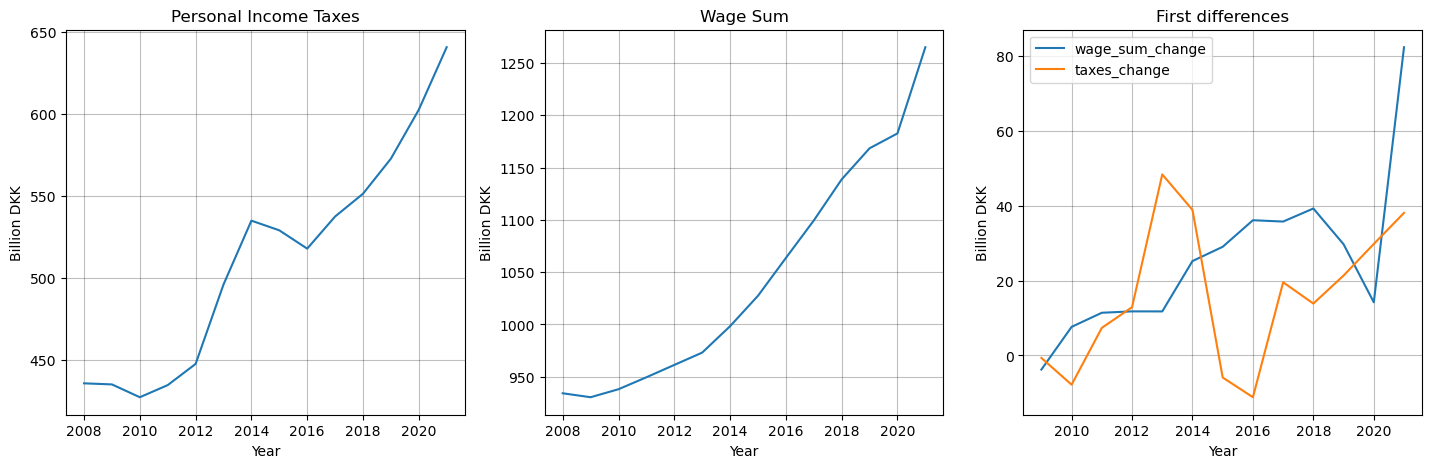

In [7]:
dataproject.plot_wages_taxes(merged)

## 3. Analyze the data

#### Let's try to see, how well we can model the tax revenue as a *simple* function of the wage sum based on the sample data.

<font size="4"> **Applied methods:**
1) Mean implicit tax rate
2) Linear regression
</font> 

#### Finally, I compare the performance of each approach.

#### **1. Mean implicit tax rate**

#### First, add the implicit tax rate as a variable:

In [8]:
# calculate the implicit tax rate in each year
merged["implicit_tax_rate"] = merged["personal_income_taxes"]/merged["wage_sum"]
merged

,year,wage_sum,personal_income_taxes,taxes_change,wage_sum_change,implicit_tax_rate
0,2008,934.155,435.865720,NaN,NaN,0.466588
1,2009,930.387,435.208167,-0.657553,-3.768,0.467771
2,2010,938.040,427.396790,-7.811377,7.653,0.455627
3,2011,949.468,434.782952,7.386162,11.428,0.457923
4,2012,961.264,447.703423,12.920471,11.796,0.465745
5,2013,973.053,496.126697,48.423274,11.789,0.509866
6,2014,998.311,535.059877,38.933180,25.258,0.535965
7,2015,1027.381,529.160244,-5.899633,29.070,0.515057
8,2016,1063.554,517.996701,-11.163543,36.173,0.487043
9,2017,1099.372,537.574707,19.578006,35.818,0.488983


#### Second, calculate the mean implicit tax rate:

In [9]:
# calculate the mean of the yearly implicit tax rate
mean_tax_rate = merged.implicit_tax_rate.mean()

print(mean_tax_rate)

0.48866012338385295


#### Then, make predictions based on the mean implicit tax rate and calculate prediction error:

In [10]:
# predicted tax revenue based on the mean implicit rax rate
merged["predicted_taxes"] = merged["wage_sum"]*mean_tax_rate

# prediction error
merged["prediction_error"] = abs(merged["personal_income_taxes"] - merged["predicted_taxes"])

merged

,year,wage_sum,personal_income_taxes,taxes_change,wage_sum_change,implicit_tax_rate,predicted_taxes,prediction_error
0,2008,934.155,435.865720,NaN,NaN,0.466588,456.484298,20.618578
1,2009,930.387,435.208167,-0.657553,-3.768,0.467771,454.643026,19.434859
2,2010,938.040,427.396790,-7.811377,7.653,0.455627,458.382742,30.985952
3,2011,949.468,434.782952,7.386162,11.428,0.457923,463.967150,29.184198
4,2012,961.264,447.703423,12.920471,11.796,0.465745,469.731385,22.027962
5,2013,973.053,496.126697,48.423274,11.789,0.509866,475.492199,20.634498
6,2014,998.311,535.059877,38.933180,25.258,0.535965,487.834776,47.225101
7,2015,1027.381,529.160244,-5.899633,29.070,0.515057,502.040126,27.120118
8,2016,1063.554,517.996701,-11.163543,36.173,0.487043,519.716429,1.719728
9,2017,1099.372,537.574707,19.578006,35.818,0.488983,537.219257,0.355450


#### **2. Linear regression:**

#### First differences of the taxes as dependent variable, and first differences of the wage sum as independent variable:

In [11]:
# get the relevant variables from the data set (excluding 2008 since we do not have first differences for this year)
Y = merged.iloc[1:,3] # the dependent variable
X = merged.iloc[1:,4] # the independent variable

# run regression
model = sm.OLS(Y, X).fit()

# get coefficient
model.params

wage_sum_change    0.472614
dtype: float64

#### Make predictions based on the regression and calculate prediction error:

In [12]:
# predicted tax revenue based on the regression
merged["predicted_taxes_reg"] = merged['personal_income_taxes'].shift(1)+merged["wage_sum_change"]*0.4726

# prediction error
merged["prediction_error_reg"] = abs(merged["personal_income_taxes"] - merged["predicted_taxes_reg"])

merged

,year,wage_sum,personal_income_taxes,taxes_change,wage_sum_change,implicit_tax_rate,predicted_taxes,prediction_error,predicted_taxes_reg,prediction_error_reg
0,2008,934.155,435.865720,NaN,NaN,0.466588,456.484298,20.618578,NaN,NaN
1,2009,930.387,435.208167,-0.657553,-3.768,0.467771,454.643026,19.434859,434.084963,1.123204
2,2010,938.040,427.396790,-7.811377,7.653,0.455627,458.382742,30.985952,438.824975,11.428185
3,2011,949.468,434.782952,7.386162,11.428,0.457923,463.967150,29.184198,432.797663,1.985289
4,2012,961.264,447.703423,12.920471,11.796,0.465745,469.731385,22.027962,440.357742,7.345681
5,2013,973.053,496.126697,48.423274,11.789,0.509866,475.492199,20.634498,453.274904,42.851793
6,2014,998.311,535.059877,38.933180,25.258,0.535965,487.834776,47.225101,508.063628,26.996249
7,2015,1027.381,529.160244,-5.899633,29.070,0.515057,502.040126,27.120118,548.798359,19.638115
8,2016,1063.554,517.996701,-11.163543,36.173,0.487043,519.716429,1.719728,546.255604,28.258903
9,2017,1099.372,537.574707,19.578006,35.818,0.488983,537.219257,0.355450,534.924288,2.650419


#### **Compare the two methods:**

#### Plot the predicted taxes for each method:

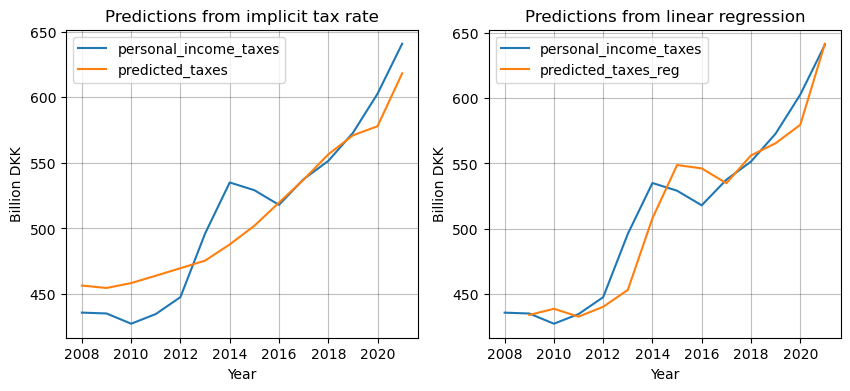

In [13]:
dataproject.plot_predicted_taxes(merged)

#### Calculate the mean prediction error:

In [17]:
# mean prediction error from implicit tax rate
mean_prediction_error = merged.prediction_error.mean()

# mean prediction error from linear regression
mean_prediction_error_reg = merged.prediction_error_reg.mean()

# print
print('Prediction errors:\n')
print('Mean implicit tax rate: ' + str(mean_prediction_error))
print('Linear regression: ' + str(mean_prediction_error_reg))

Prediction errors:

Mean implicit tax rate: 19.53595744324428
Linear regression: 13.710107861538443


#### **Prediction error:** Approximately 19.5 and 13.7 billion DKK mean prediction error. It is not surprising that the linear regression performs better than the mean tax rate in-sample, as it is corresponds to the conditional mean.

<font size="4"> **Conclusion:** To make better predictions, it is likely that one would need more data. On the one hand, data for more years is nice, but on the other hand, changes in the personal tax system throughout the years affect the implicit tax rate. Therefore, data for more years alone is unlikely to improve the predictions. To accurately predict the personal income tax, it is probably necessary make a more detailed model that takes into account taxed income sources other than wages, the income distribution etc.
</font> 